## Fine Tuning Transformer (DistilBert) for MultiClass Text Classification (Project types based on description)

### Introduction

In this project we will be fine tuning a transformer model (DistilBert) for the **Multiclass text classification** problem.
Given a Project description the model will classify into one of the project categories out of the given list.

#### Flow of the notebook

The notebook will be divided into separate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning and validating the Model](#section05)
6. [Saving the model and artifacts for Inference in Future](#section07) (to be implement)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data:
	 - We are using Project Descriptions from   Portuguese Public Administration site of Contract  aggregator dataset available at [base.gov Repository](https://https://www.base.gov.pt/base4)
	 - We are referring only to a small example  csv file from the data dump: `ContratosAP_v5.2_TrainPred.xlsx`
	 - There are `751` rows of data.  Where each row has the following data-point:
		 - Objeto do Contrato: Contract Object
		 - Contrato (Tipo): Type of Contract (see categories below)

 - Language Model Used:
	 - DistilBERT this is a smaller transformer model as compared to BERT or Roberta. It is created by process of distillation applied to Bert.
	 - [Blog-Post](https://medium.com/huggingface/distilbert-8cf3380435b5)
	 - [Research Paper](https://arxiv.org/abs/1910.01108)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/distilbert.html)


 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup


 - Script Objective:
	 - The objective of this script is to fine tune DistilBERT project

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Numpy
* Pandas
* Pytorch
* Dataset
* Transformers
* AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments,  Trainer
* Evaluate

Followed by that we will prepare the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU.

In [1]:
# Installing libraries (Transformers, datasets, evaluate) needed
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install transformers[torch]

# Importing the libraries needed
import numpy as np
import pandas as pd
import torch
import transformers
from datasets import Dataset #from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForPreTraining, TrainingArguments,  Trainer #DistilBertModel, DistilBertTokenizer
import evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.1 MB/s eta 0:00:00


In [2]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print ("Using device ", device)

Using device  cuda


<a id='section02'></a>
### Importing and Preparing the domain data

We will be working with the data and preparing for fine tuning purposes.
*Assuming that the `ContratosAP_v5.2_TrainPred.xlsx` is already downloaded in your `data` folder*.

Import the file in a dataframe.
Remove the unwanted columns, rename labels.
The final Dataframe will be something like this:

|Objeto do Contrato|Contrato (Tipo)||
|--|--|--|
|  contract_description_1 | 2 |
|  contract_description_2 | 6 |
|  contract_description_3 | 3 |
|  contract_description_4 | 1 |
|  contract_description_5 | 5 |
|  contract_description_6 | 7 |

If you like, you can create a smaller subset of the full dataset to fine-tune on to reduce the time it takes.



In [3]:
# Import the xls into pandas dataframe
PathFileName = '/content/sample_data/ContratosAP_v5.2_TrainPred.xlsx'
contratsAPFit = pd.read_excel(PathFileName,'DadosTreinoVal') #all dataset with contracts (train&test)
# Removing unwanted columns and only leaving project description and the category which will be the target
contratsAPFit = contratsAPFit[['Objeto do Contrato','Contrato (Tipo)']]

# Create a dataset from the pandas dataframe
dataset = Dataset.from_pandas(contratsAPFit)
# Rename column name (labels for Transformer Model)
dataset = dataset.rename_column ("Contrato (Tipo)", "labels")

# option to reduce dataset size (Max 751)
dataset = dataset.select (range(751))



<a id='section03'></a>
### Pre-Processing the Dataset

We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by Spliting the dataset into a dictionary with dataset train and test (for the Transformer model).
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training.

#### Dataset Tokenization
- We are using the DistilBERT tokenizer to tokenize the data
- To process your dataset in one step, use Datasets map method to apply a preprocessing function over the entire dataset
- The tokenizer perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`
- Remove "Objeto do Contrato" column
- `label` is the encoded category on the project description
- Format pytorch ("torch")
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)



In [4]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-05
MAXIMUM_SEQ_LENGHT = 256
WEIGHT_DECAY = 0.01

# split the dataset into a dictionary with dataset train and test
dataset = dataset.train_test_split(test_size=0.2) #, stratify_by_column="Labels")
print("dataset ", dataset)

# Dataset Tokenization
modelnameused=  "distilbert-base-multilingual-cased" #49% accuracy #"adalbertojunior/distilbert-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(modelnameused)   # do_lower_case=False just for Adalberto

def tokenize_function(examples):
    return tokenizer(examples["Objeto do Contrato"], padding="max_length", truncation=True)

tokenized_contratsAPFit = dataset.map(tokenize_function, batched=True) #map for apply to all the dictionary of datasets

tokenized_contratsAPFit = tokenized_contratsAPFit.remove_columns ("Objeto do Contrato")
tokenized_contratsAPFit = tokenized_contratsAPFit.with_format ("torch")

dataset  DatasetDict({
    train: Dataset({
        features: ['Objeto do Contrato', 'labels'],
        num_rows: 600
    })
    test: Dataset({
        features: ['Objeto do Contrato', 'labels'],
        num_rows: 151
    })
})


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `distilbert-base-multilingual-cased`.
 - Defining training_args and compute metrics


In [5]:

# Train with AutoModelForSequenceClassification

# labels = 8
model = AutoModelForSequenceClassification.from_pretrained(modelnameused, num_labels=8)
#model = AutoModelForPreTraining.from_pretrained('adalbertojunior/distilbert-portuguese-cased') #for Adalberto


training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    per_device_train_batch_size=TRAIN_BATCH_SIZE, #16,
    per_device_eval_batch_size=VALID_BATCH_SIZE, #16,
    num_train_epochs=EPOCHS, #3,
    learning_rate=LEARNING_RATE, #2e-5, #1e-5
    # maximum sequence length = MAXIMUM_SEQ_LENGHT
    weight_decay=WEIGHT_DECAY, #0.01,
)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def draw_confusion_matrix (predictions , labels):
  print ("Confusion Matrix: Focus on  classification Challenges")
  cm = confusion_matrix(labels, predictions)
  ConfusionMatrixDisplay(cm).plot()


metric = evaluate.load("accuracy")

#Call compute on metric to calculate the accuracy of your predictions. Before passing your predictions to compute, you need to convert the predictions to logits (remember all 🤗 Transformers models return logits):
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    print ("predictions ", predictions)
    print ("labels      ", labels)
    draw_confusion_matrix (predictions , labels)
    return metric.compute(predictions=predictions, references=labels)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<a id='section05'></a>
### Fine Tuning and validating the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its variabels. This is probably the easier steps in the process.

Here we create a Trainer object with your model, training arguments, training and test datasets, and evaluation function.

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

See Confusion Matrix of last prediction iteration




Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.711388,0.483444
2,No log,1.551106,0.496689
3,No log,1.459548,0.509934


predictions  [4 4 4 4 4 4 4 3 4 4 3 3 3 4 4 4 4 3 4 4 3 3 4 4 4 4 4 3 3 4 4 4 4 3 4 4 4
 3 3 4 4 4 4 3 4 4 3 3 4 4 3 4 4 4 4 4 3 3 4 4 3 4 4 4 3 3 4 3 4 4 3 3 4 4
 3 4 4 3 3 4 4 3 3 3 3 3 4 4 4 3 4 3 4 4 3 4 4 3 3 3 4 4 4 4 4 3 3 4 4 4 4
 4 4 4 4 4 4 4 4 3 4 4 4 4 3 4 3 3 3 4 4 4 4 4 3 4 3 3 3 3 3 3 3 4 3 3 3 4
 4 4 4]
labels       [3 4 4 4 1 3 4 3 3 4 1 5 4 2 4 4 7 3 6 4 0 4 6 1 4 4 4 3 2 4 4 4 4 0 3 3 4
 7 3 4 0 4 3 7 4 7 2 3 4 4 3 6 1 7 7 4 4 3 4 3 3 3 6 4 2 3 3 2 4 4 5 4 3 1
 3 4 0 3 7 2 1 3 3 1 3 3 6 2 3 3 4 4 4 2 3 7 1 3 4 5 2 3 3 4 5 5 2 4 1 4 4
 4 2 6 2 4 2 4 4 3 3 4 4 4 7 6 0 3 3 4 4 4 4 0 0 4 6 0 3 4 3 3 3 6 2 3 2 4
 6 3 4]
Confusion Matrix: Focus on  classification Challenges
predictions  [4 4 3 4 4 3 4 3 3 3 3 3 3 3 4 4 3 3 4 4 3 3 4 4 4 4 4 3 3 4 4 4 4 3 4 4 4
 3 3 4 3 4 4 3 4 4 3 3 3 4 3 4 4 3 4 4 3 3 4 3 3 4 4 4 3 3 3 3 4 4 3 3 3 4
 3 4 3 3 3 4 4 3 3 3 3 3 4 3 3 3 4 3 4 3 3 4 3 3 3 3 4 3 3 4 4 3 3 4 4 4 4
 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 3 3 3 4 3 4 4 3 3 4 4 3 3 3 3 3 3 4

TrainOutput(global_step=114, training_loss=1.7045571845874452, metrics={'train_runtime': 104.4334, 'train_samples_per_second': 17.236, 'train_steps_per_second': 1.092, 'total_flos': 238466831155200.0, 'train_loss': 1.7045571845874452, 'epoch': 3.0})

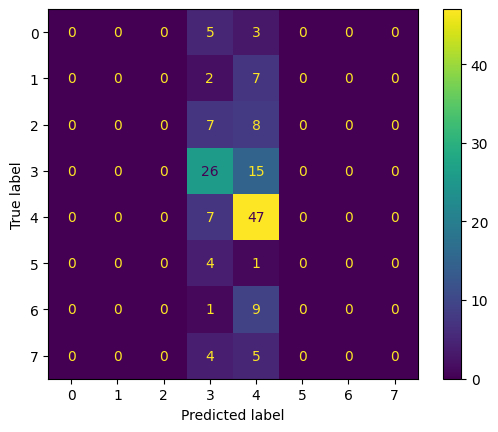

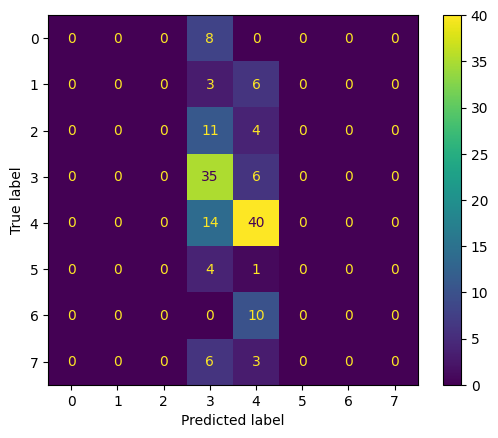

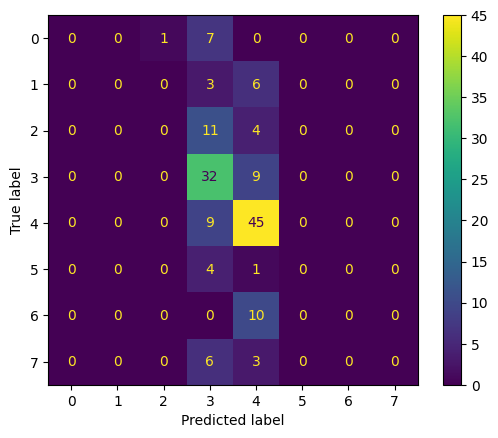

In [6]:
#Create a Trainer object with your distilbert model, training arguments, training and test datasets, and evaluation function:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_contratsAPFit["train"], #tokenized_contratsAPFit_train_dataset
    eval_dataset=tokenized_contratsAPFit["test"], #tokenized_contratsAPFit_test_dataset
    compute_metrics=compute_metrics,
)

#Then fine-tune your model by calling train():
trainer.train()


<a id='section06'></a>
### Saving the Trained Model Artifacts for inference (to be implement)


This is the final step in the process of fine tuning the model.

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

Please remember that a trained neural network is only useful when used in actual inference after its training.

In the lifecycle of an ML projects this is only half the job done. We will leave the inference of these models for some other day.